In [1]:
# construct 'PairTrading' class
# object-oriented program

In [2]:
import re
import pandas as pd
import numpy as np
from arch.unitroot import ADF
import statsmodels.api as sm

In [3]:
class PairTrading:
    def SSD(self,priceX,priceY):
        if priceX is None or priceY is None:
            print('lack price series')
        returnX=(priceX-priceX.shift(1))/priceX.shift(1)[1:]
        returnY=(priceY-priceY.shift(1))/priceY.shift(1)[1:]
        standardX=(1+returnX).cumprod()
        standardY=(1+returnY).cumprod()
        SSD=np.sum((standardY-standardX)**2)
        return(SSD)
    def SSDSpread(self,priceX,priceY):
        if priceX is None or priceY is None:
            print('lack price series')
        retx=(priceX-priceX.shift(1))/priceX.shift(1)[1:]
        rety=(priceY-priceY.shift(1))/priceY.shift(1)[1:]
        standardX=(1+retx).cumprod()
        standardY=(1+rety).cumprod()
        spread=standardY-standardX
        return(spread)
    def cointegration(self,priceX,priceY):
        if priceX is None or priceY is None:
            print('lack price series')
        priceX=np.log(priceX)
        priceY=np.log(priceY)
        results=sm.OLS(priceY,sm.add_constant(priceX)).fit()
        resid=results.resid
        adfSpread=ADF(resid)
        if adfSpread.pvalue>=0.05:
            print('''Trading price do not have cointegration relationship.
            P-value of ADF test: %f
            Coefficients of regression:
            Intercept: %f
            Beta: %f
            '''%(adfSpread.pvalue,results.params[0],results.params[1]))
            return(None)
        else:
            print('''Trading price have cointegration relationship.
            P-value of ADF test: %f
            Coefficients of regression:
            Intercept: %f
            Beta: %f
            '''%(adfSpread.pvalue,results.params[0],results.params[1]))
            return(results.params[0],results.params[1])
    def CointegrationSpread(self,priceX,priceY,formPeriod,tradePeriod):
        if priceX is None or priceY is None:
            print('lack price series')
        if not (re.fullmatch('\d{4}-\d{2}-\d{2}:\d{4}-\d{2}-\d{2}',formPeriod)
                or re.fullmatch('\d{4}-\d{2}-\d{2}:\d{4}-\d{2}-\d{2}',tradePeriod)):
            print('format error of formation period.')
        formX=priceX[formPeriod.split(':')[0]:formPeriod.split(':')[1]]
        formY=priceY[formPeriod.split(':')[0]:formPeriod.split(':')[1]]
        coefficients=self.cointegration(formX,formY)
        if coefficients is None:
                print('no cointegration relationship, can not cointegration.')
        else:
            spread=(np.log(priceY[tradePeriod.split(':')[0]:tradePeriod.split(':')[1]])
                    -coefficients[0]-coefficients[1]*np.log(priceX[tradePeriod.split(':')[0]:tradePeriod.split(':')[1]]))
            return(spread)
    def calBound(self,priceX,priceY,method,formPeriod,width=1.5):
        if not (re.fullmatch('\d{4}-\d{2}-\d{2}:\d{4}-\d{2}-\d{2}',formPeriod)
                or re.fullmatch('\d{4}-\d{2}-\d{2}:\d{4}-\d{2}-\d{2}',tradePeriod)):
            print('format error of formation period.')
        if method=='SSD':
            spread=self.SSDSpread(priceX[formPeriod.split(':')[0]:formPeriod.split(':')[1]],
                                  priceY[formPeriod.split(':')[0]:formPeriod.split(':')[1]])            
            mu=np.mean(spread)
            sd=np.std(spread)
            UpperBound=mu+width*sd
            LowerBound=mu-width*sd
            return(UpperBound,LowerBound)
        elif method=='Cointegration':
            spread=self.CointegrationSpread(priceX,priceY,formPeriod,formPeriod)
            mu=np.mean(spread)
            sd=np.std(spread)
            UpperBound=mu+width*sd
            LowerBound=mu-width*sd
            return(UpperBound,LowerBound)
        else:
            print('does not exist. please choose "SSD" or "Cointegration".')

In [14]:
sh=pd.read_csv('sh50p.csv',index_col='Trddt')
sh.index=pd.to_datetime(sh.index)
formPeriod='2014-01-01:2015-01-01'
tradePeriod='2015-01-01:2015-06-30'
priceA=sh['601988']
priceB=sh['600000']
priceAf=priceA[formPeriod.split(':')[0]:formPeriod.split(':')[1]]
priceBf=priceB[formPeriod.split(':')[0]:formPeriod.split(':')[1]]
priceAt=priceA[tradePeriod.split(':')[0]:tradePeriod.split(':')[1]]
priceBt=priceB[tradePeriod.split(':')[0]:tradePeriod.split(':')[1]]
pt=PairTrading()

In [15]:
SSD=pt.SSD(priceAf,priceBf)
SSD

0.47481704588389073

In [16]:
SSDspread=pt.SSDSpread(priceAf,priceBf)
SSDspread.describe()

count    244.000000
mean       0.020185
std        0.039305
min       -0.042896
25%       -0.009463
50%        0.012243
75%        0.041418
max        0.171011
dtype: float64

In [17]:
SSDspread.head()

Trddt
2014-01-02         NaN
2014-01-03   -0.001484
2014-01-06    0.015385
2014-01-07    0.013946
2014-01-08    0.024184
dtype: float64

In [18]:
coefficients=pt.cointegration(priceAf,priceBf)
coefficients

True
Trading price have cointegration relationship.
            P-value of ADF test: 0.020415
            Coefficients of regression:
            Intercept: 1.226852
            Beta: 1.064103
            


(1.2268515742404387, 1.0641034525888144)

In [19]:
CoSpreadF=pt.CointegrationSpread(priceA,priceB,formPeriod,formPeriod)
CoSpreadF.head()

True
Trading price have cointegration relationship.
            P-value of ADF test: 0.020415
            Coefficients of regression:
            Intercept: 1.226852
            Beta: 1.064103
            


Trddt
2014-01-02   -0.011214
2014-01-03   -0.011507
2014-01-06    0.006511
2014-01-07    0.005361
2014-01-08    0.016112
dtype: float64

In [20]:
CoSpreadTr=pt.CointegrationSpread(priceA,priceB,formPeriod,tradePeriod)
CoSpreadTr.describe()

True
Trading price have cointegration relationship.
            P-value of ADF test: 0.020415
            Coefficients of regression:
            Intercept: 1.226852
            Beta: 1.064103
            


count    119.000000
mean      -0.037295
std        0.052204
min       -0.163903
25%       -0.063038
50%       -0.033336
75%        0.000503
max        0.057989
dtype: float64

In [21]:
bound=pt.calBound(priceA,priceB,'Cointegration',formPeriod,width=1.2)
bound

True
Trading price have cointegration relationship.
            P-value of ADF test: 0.020415
            Coefficients of regression:
            Intercept: 1.226852
            Beta: 1.064103
            


(0.03627938704534019, -0.03627938704533997)

In [22]:
# Then we use these features and stats to trade
# procedures:
# 1. in the formation period, test the cointegration property
# 2. find the proportion \alpha and \beta to calculate the spread
# 3. compute threshold value and corresponding strategies
# 4. evaluate performance

In [24]:
# import data
formStart='2014-01-01'
formEnd='2015-01-01'
PA=sh['601988']
PB=sh['600000']
PAf=PA[formStart:formEnd]
PBf=PB[formStart:formEnd]

In [25]:
# Bank of China 1st order integration test
log_PAf=np.log(PAf)
adfA=ADF(log_PAf)
print(adfA.summary().as_text())

True
   Augmented Dickey-Fuller Results   
Test Statistic                  3.409
P-value                         1.000
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [27]:
adfAd=ADF(log_PAf.diff()[1:])
print(adfAd.summary().as_text())

True
   Augmented Dickey-Fuller Results   
Test Statistic                 -4.571
P-value                         0.000
Lags                               11
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [28]:
# Pu Fa Bank 1st order integration test
log_PBf=np.log(PBf)
adfB=ADF(log_PBf)
print(adfB.summary().as_text())

True
   Augmented Dickey-Fuller Results   
Test Statistic                  2.392
P-value                         0.999
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [29]:
adfBd=ADF(log_PBf.diff()[1:])
print(adfBd.summary().as_text())

True
   Augmented Dickey-Fuller Results   
Test Statistic                 -3.888
P-value                         0.002
Lags                               11
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [30]:
# cointegration test
model=sm.OLS(log_PBf,sm.add_constant(log_PAf)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 600000   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     4560.
Date:                Mon, 29 Oct 2018   Prob (F-statistic):          1.83e-159
Time:                        17:05:57   Log-Likelihood:                 509.57
No. Observations:                 245   AIC:                            -1015.
Df Residuals:                     243   BIC:                            -1008.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2269      0.015     83.071      0.000       1.198       1.256
601988         1.0641      0.016     67.531      0.000       1.033       1.095
==============================================================================
Omnibus:                       19.538   Durbin-Watson:                   0.161
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.245
Skew:                           0.444   Prob(JB):                      0.00133
Kurtosis:                       2.286   Cond. No.                         15.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
# residue unit root test
alpha=model.params[0]
beta=model.params[1]
spreadf=log_PBf-beta*log_PAf-alpha
adfSpread=ADF(spreadf)
print(adfSpread.summary().as_text())
# indeed cointegration relationship

True
   Augmented Dickey-Fuller Results   
Test Statistic                 -3.193
P-value                         0.020
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [34]:
# pairing
mu=np.mean(spreadf)
sd=np.std(spreadf)

In [35]:
# trading days, determine position interval
tradStart='2015-01-01'
tradEnd='2015-06-30'
PAt=PA[tradStart:tradEnd]
PBt=PB[tradStart:tradEnd]
CoSpreadT=np.log(PBt)-beta*np.log(PAt)-alpha
CoSpreadT.describe()

count    119.000000
mean      -0.037295
std        0.052204
min       -0.163903
25%       -0.063038
50%       -0.033336
75%        0.000503
max        0.057989
dtype: float64

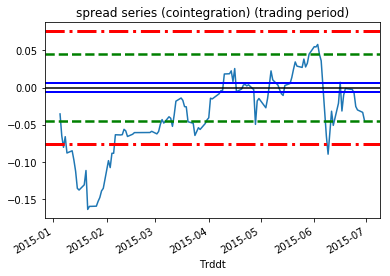

In [37]:
# plot spread interval
import matplotlib.pyplot as plt 
CoSpreadT.plot()
plt.title('spread series (cointegration) (trading period)')
plt.axhline(y=mu,color='black')
plt.axhline(y=mu+0.2*sd,color='blue',ls='-',lw=2)
plt.axhline(y=mu-0.2*sd,color='blue',ls='-',lw=2)
plt.axhline(y=mu+1.5*sd,color='green',ls='--',lw=2.5)
plt.axhline(y=mu-1.5*sd,color='green',ls='--',lw=2.5)
plt.axhline(y=mu+2.5*sd,color='red',ls='-.',lw=3)
plt.axhline(y=mu-2.5*sd,color='red',ls='-.',lw=3)

In [40]:
# according to the plot above, we trade with this strategy and simulate the market
level=(float('-inf'),mu-2.5*sd,mu-1.5*sd,mu-0.2*sd,mu+0.2*sd,mu+1.5*sd,mu+2.5*sd,float('inf'))
prcLevel=pd.cut(CoSpreadT,level,labels=False)-3
prcLevel.head()

Trddt
2015-01-05   -1
2015-01-06   -2
2015-01-07   -3
2015-01-08   -2
2015-01-09   -3
dtype: int64

In [41]:
# signals
def TradeSig(prcLevel):
    n=len(prcLevel)
    signal=np.zeros(n)
    for i in range(1,n):
        if prcLevel[i-1]==1 and prcLevel[i]==2:
            signal[i]=-2
        elif prcLevel[i-1]==1 and prcLevel[i]==0:
            signal[i]=2
        elif prcLevel[i-1]==2 and prcLevel[i]==3:
            signal[i]=3
        elif prcLevel[i-1]==-1 and prcLevel[i]==-2:
            signal[i]=1
        elif prcLevel[i-1]==-1 and prcLevel[i]==0:
            signal[i]=-1
        elif prcLevel[i-1]==-2 and prcLevel[i]==-3:
            signal[i]=-3
    return(signal)

In [42]:
signal=TradeSig(prcLevel)
position=[signal[0]]
ns=len(signal)

In [44]:
for i in range(1,ns):
    position.append(position[-1])
    if signal[i]==1:
        position[i]=1
    elif signal[i]==-2:
        position[i]=-1
    elif signal[i]==-1 and position[i-1]==1:
        position[i]=0
    elif signal[i]==2 and position[i-1]==-1:
        position[i]=0
    elif signal[i]==3:
        position[i]=0
    elif signal[i]==-3:
        position[i]=0

In [45]:
position=pd.Series(position,index=CoSpreadT.index)
position.tail()

Trddt
2015-06-24    0.0
2015-06-25    0.0
2015-06-26    0.0
2015-06-29    0.0
2015-06-30    0.0
dtype: float64

In [48]:
# simulate tradings
def TradeSim(priceX,priceY,position):
    n=len(position)
    size=1000
    shareY=size*position
    shareX=[(-beta)*shareY[0]*priceY[0]/priceX[0]]
    cash=[2000]
    for i in range(1,n):
        shareX.append(shareX[i-1])
        cash.append(cash[i-1])
        if position[i-1]==0 and position[i]==1:
            shareX[i]=(-beta)*shareY[i]*priceY[i]/priceX[i]
            cash[i]=cash[i-1]-(shareY[i]*priceY[i]+shareX[i]*priceX[i])
        elif position[i-1]==0 and position[i]==-1:
            shareX[i]=(-beta)*shareY[i]*priceY[i]/priceX[i]
            cash[i]=cash[i-1]-(shareY[i]*priceY[i]+shareX[i]*priceX[i])
        elif position[i-1]==1 and position[i]==-0:
            shareX[i]=0
            cash[i]=cash[i-1]+(shareY[i-1]*priceY[i]+shareX[i-1]*priceX[i])
        elif position[i-1]==-1 and position[i]==-0:
            shareX[i]=0
            cash[i]=cash[i-1]+(shareY[i-1]*priceY[i]+shareX[i-1]*priceX[i])
    cash=pd.Series(cash,index=position.index)
    shareY=pd.Series(shareY,index=position.index)
    shareX=pd.Series(shareX,index=position.index)
    asset=cash+shareY*priceY+shareX*priceX
    account=pd.DataFrame({'Position':position,'ShareY':shareY,'ShareX':shareX,'Cash':cash,'Asset':asset})
    return(account)

In [50]:
account=TradeSim(PAt,PBt,position)
account.tail()

,Position,ShareY,ShareX,Cash,Asset
Trddt,,,,,
2015-06-24,0.0,0.0,0.0,5992.514,5992.514
2015-06-25,0.0,0.0,0.0,5992.514,5992.514
2015-06-26,0.0,0.0,0.0,5992.514,5992.514
2015-06-29,0.0,0.0,0.0,5992.514,5992.514
2015-06-30,0.0,0.0,0.0,5992.514,5992.514


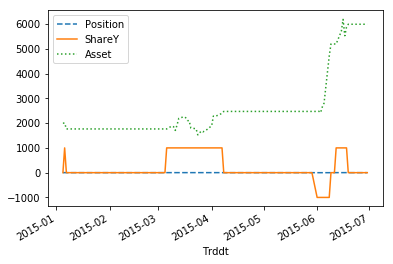

In [56]:
account.iloc[:,[0,1,4]].plot(style=['--','-',':'])
# plot may be wrong, but the procedure is certainly correct